# Load Dataset

### Import Libraries

In [201]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import pandas as pd

### Load Historical Prices

In [202]:
# Load environment variables
load_dotenv()

# MongoDB Connection Setup
MONGO_URI = os.getenv("MONGO_URI")
if not MONGO_URI:
    raise ValueError("MONGO_URI not found in environment variables. Please check your .env file.")

DATABASE_NAME = "robo_advisor"
HISTORICAL_PRICES_COLLECTION = "historical_prices"

# Load Historical Prices
def load_historical_prices():
    client = MongoClient(MONGO_URI)
    db = client[DATABASE_NAME]
    collection = db[HISTORICAL_PRICES_COLLECTION]
    
    # Fetch all historical prices
    data = list(collection.find({}, {"_id": 0}))  # Exclude MongoDB `_id` field for simplicity
    if not data:
        print("No data found in historical_prices collection.")
        return pd.DataFrame()
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} records from historical_prices collection.")
    return df

# Load and display
historical_prices_df = load_historical_prices()
historical_prices_df.head()
historical_prices_df.info()

Loaded 883859 records from historical_prices collection.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883859 entries, 0 to 883858
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    883859 non-null  object        
 1   Asset                   883859 non-null  object        
 2   Close                   883859 non-null  float64       
 3   last_updated            883859 non-null  object        
 4   last_updated_timestamp  883859 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 33.7+ MB


### Standardize numeric field 'Close'

In [203]:
# Process and update "Close" values for "TECHY"
historical_prices_df.loc[historical_prices_df['Asset'] == 'TCEHY', 'Close'] = (
    historical_prices_df.loc[historical_prices_df['Asset'] == 'TCEHY', 'Close']
    .apply(lambda x: float(x.replace('$', '')) if isinstance(x, str) else x)  # Strip $ and convert to float
)

# Verify if the update was successful
print(historical_prices_df[historical_prices_df['Asset'] == 'TCEHY'][['Asset', 'Close']].head())

# Check the type after the update
print("After update:", historical_prices_df['Close'].dtype)

        Asset  Close
222191  TCEHY  51.86
222192  TCEHY  50.13
222193  TCEHY  55.04
222194  TCEHY  62.35
222195  TCEHY  48.40
After update: float64


### Put the cleaned data back to mongodb

In [204]:
client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]
collection = db[HISTORICAL_PRICES_COLLECTION]

# Update MongoDB with the new Close values for 'TCEHY'
for index, row in historical_prices_df[historical_prices_df['Asset'] == 'TCEHY'].iterrows():
    collection.update_one(
        {'Asset': 'TCEHY', 'Date': row['Date']},  # Match the document by Asset and _id (if _id exists)
        {'$set': {'Close': row['Close']}}  # Update the "Close" value
    )
print("TCEHY Close values updated in MongoDB.")

TCEHY Close values updated in MongoDB.


In [205]:
historical_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883859 entries, 0 to 883858
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    883859 non-null  object        
 1   Asset                   883859 non-null  object        
 2   Close                   883859 non-null  float64       
 3   last_updated            883859 non-null  object        
 4   last_updated_timestamp  883859 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 33.7+ MB


### Load Asset Metadata

In [206]:
# Asset Metadata Collection
ASSET_METADATA_COLLECTION = "asset_metadata"

# Load Asset Metadata
def load_asset_metadata():
    client = MongoClient(MONGO_URI)
    db = client[DATABASE_NAME]
    collection = db[ASSET_METADATA_COLLECTION]
    
    # Fetch all asset metadata
    data = list(collection.find({}, {"_id": 0}))  # Exclude MongoDB `_id` field for simplicity
    if not data:
        print("No data found in asset_metadata collection.")
        return pd.DataFrame()
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} records from asset_metadata collection.")
    return df

# Load and display
asset_metadata_df = load_asset_metadata()
print(asset_metadata_df.head())
print(asset_metadata_df.info())

Loaded 116 records from asset_metadata collection.
  Ticker Asset_Type                  Sector                        Industry  \
0    AMD     EQUITY              Technology                  Semiconductors   
1   COKE     EQUITY      Consumer Defensive       Beverages - Non-Alcoholic   
2     EA     EQUITY  Communication Services  Electronic Gaming & Multimedia   
3    IEF        ETF                     N/A                             N/A   
4    JPM     EQUITY      Financial Services             Banks - Diversified   

  Exchange Currency                                        Description  \
0      NMS      USD  Advanced Micro Devices, Inc. operates as a sem...   
1      NMS      USD  Coca-Cola Consolidated, Inc., together with it...   
2      NMS      USD  Electronic Arts Inc. develops, markets, publis...   
3      NGM      USD  The underlying index measures the performance ...   
4      NYQ      USD  JPMorgan Chase & Co. operates as a financial s...   

          1Y          3Y     

### Standardize numeric fields

In [207]:
# Convert to numeric, coercing errors to NaN (invalid entries like 'N/A' will become NaN)
asset_metadata_df['Average_Dividend_per_Share'] = pd.to_numeric(
    asset_metadata_df['Average_Dividend_per_Share'], errors='coerce'
)

# Replace NaN values with 0
asset_metadata_df['Average_Dividend_per_Share'] = asset_metadata_df['Average_Dividend_per_Share'].fillna(0)

# Verify the type
print(asset_metadata_df['Average_Dividend_per_Share'].dtype)

float64


### Put the cleaned data back to mongodb

In [208]:
client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]
collection = db[ASSET_METADATA_COLLECTION]

# Iterate through the asset_metadata_df and update the MongoDB collection
for index, row in asset_metadata_df.iterrows():
    collection.update_one(
        {'Ticker': row['Ticker']},  # Match document by 'Ticker'
        {'$set': {'Average_Dividend_per_Share': row['Average_Dividend_per_Share']}}  # Update 'Average_Dividend_per_Share'
    )

print("Values updated in MongoDB.")

Values updated in MongoDB.


# Data Cleaning

### Check if there are any missing values

Visualizing missing values for 'historical_prices':
No missing values detected.

Visualizing missing values for 'asset_metadata':
Total missing values: 10


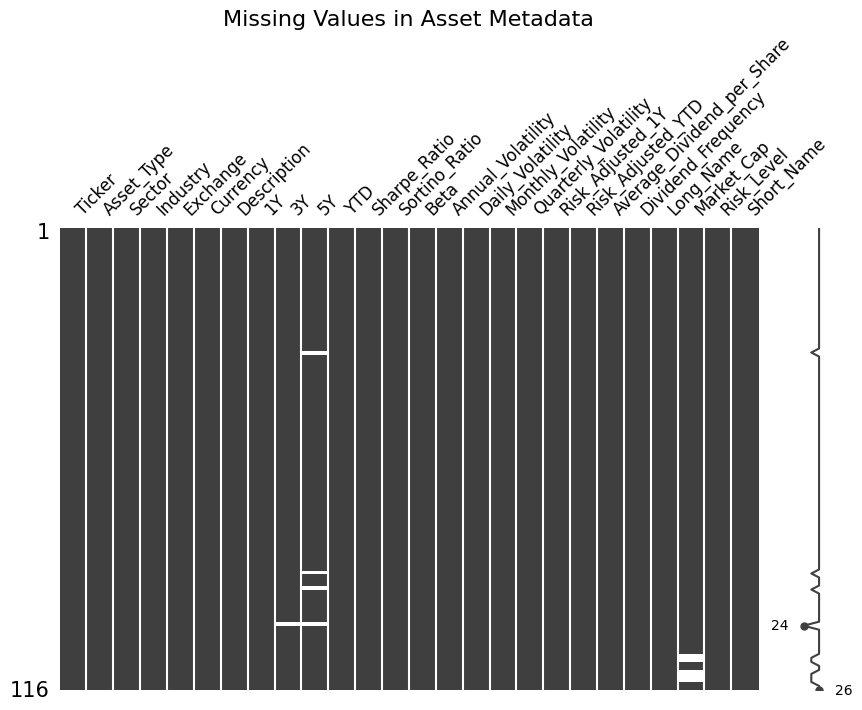

In [209]:
import missingno as msno
import matplotlib.pyplot as plt

# Function to visualize missing values
def visualize_missing_values(df, title="Missing Values"):
    if df.isnull().sum().sum() == 0:
        print("No missing values detected.")
        return
    
    print(f"Total missing values: {df.isnull().sum().sum()}")
    msno.matrix(df, figsize=(10, 6), fontsize=12)
    plt.title(title, fontsize=16)
    plt.show()

# Visualize missing values for historical_prices
print("Visualizing missing values for 'historical_prices':")
visualize_missing_values(historical_prices_df, title="Missing Values in Historical Prices")

# Visualize missing values for asset_metadata
print("\nVisualizing missing values for 'asset_metadata':")
visualize_missing_values(asset_metadata_df, title="Missing Values in Asset Metadata")

### Analyze missing market cap 

In [210]:
# Filter the DataFrame for rows where Market Cap is NaN, N/A or None
missing_market_cap_tickers = asset_metadata_df[
    asset_metadata_df["Market_Cap"].isna() | 
    asset_metadata_df["Market_Cap"].isin(['N/A', 'null', 'None', ''])  # Add more placeholders here
]["Ticker"].tolist()

# Print the tickers
print("Tickers with missing Market Cap:", missing_market_cap_tickers)

Tickers with missing Market Cap: ['IEF', 'DIA', 'IWM', 'AGG', 'HYG', 'TLT', 'VEA', 'BND', 'EEM', 'GLD', 'SPY', 'EFA', 'SHY', 'LQD', 'QQQ', 'XLK', 'VWO', 'XLE', 'XLF', 'XLV', 'XLY', 'ARKK', 'DBA', 'GNOM', 'ICLN', 'SLV', 'TAN', 'USO', 'WEAT', 'XBB', 'UNG', 'PDBC', 'FNGU', 'INDU', 'NDX', 'NQX', 'USD']


### Analyze missing returns

In [211]:
# Check for tickers with missing 1Y return
missing_1y_tickers = asset_metadata_df[asset_metadata_df["1Y"].isna()]["Ticker"].tolist()
print("Tickers with missing 1Y returns:", missing_1y_tickers)

# Check for tickers with missing 3Y return
missing_3y_tickers = asset_metadata_df[asset_metadata_df["3Y"].isna()]["Ticker"].tolist()
print("Tickers with missing 3Y returns:", missing_3y_tickers)

# Check for tickers with missing 5Y return
missing_5y_tickers = asset_metadata_df[asset_metadata_df["5Y"].isna()]["Ticker"].tolist()
print("Tickers with missing 5Y returns:", missing_5y_tickers)

# Check for tickers with missing YTD return
missing_ytd_tickers = asset_metadata_df[asset_metadata_df["YTD"].isna()]["Ticker"].tolist()
print("Tickers with missing YTD returns:", missing_ytd_tickers)

Tickers with missing 1Y returns: []
Tickers with missing 3Y returns: ['XBB']
Tickers with missing 5Y returns: ['PLTR', 'RIVN', 'SNOW', 'XBB']
Tickers with missing YTD returns: []


### Check the earliest date for available data

In [212]:
tickers_to_check = ['PLTR', 'RIVN', 'SNOW', 'XBB']

# Ensure 'Date' is in datetime format
historical_prices_df['Date'] = pd.to_datetime(historical_prices_df['Date'], errors='coerce')

# Filter rows and compute the minimum date for each ticker
min_dates = (
    historical_prices_df[historical_prices_df['Asset'].isin(tickers_to_check)]
    .groupby('Asset')['Date']
    .min()
)

print(min_dates)

Asset
PLTR   2020-09-30
RIVN   2021-11-10
SNOW   2020-09-17
XBB    2022-05-26
Name: Date, dtype: datetime64[ns]


### Check missing sharpe_ratio

In [213]:
# Check for tickers with missing 1Y return
missing_1y_tickers = asset_metadata_df[asset_metadata_df["Sharpe_Ratio"].isna()]["Ticker"].tolist()
print("Tickers with missing 1Y returns:", missing_1y_tickers)

Tickers with missing 1Y returns: []



Visualizing missing values for 'asset_metadata':
Total missing values: 10


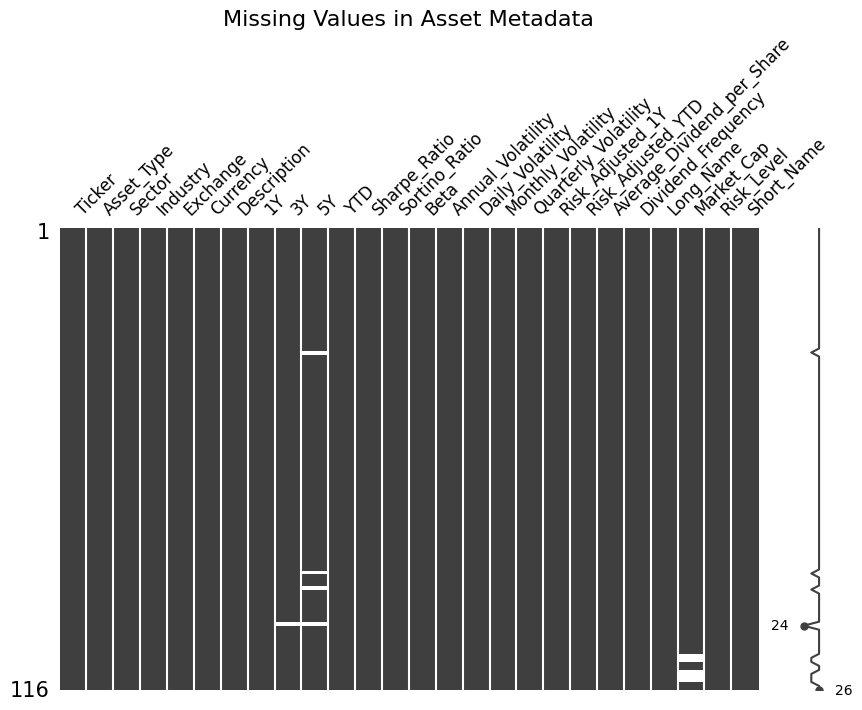

In [214]:
# Visualize missing values for asset_metadata
print("\nVisualizing missing values for 'asset_metadata':")
visualize_missing_values(asset_metadata_df, title="Missing Values in Asset Metadata")

### Check Risk_Adjusted_1Y or Risk_Adjusted_YTD

In [215]:
# Find tickers with missing values in either Risk_Adjusted_1Y or Risk_Adjusted_YTD
missing_tickers = asset_metadata_df[
    asset_metadata_df["Risk_Adjusted_1Y"].isna() | asset_metadata_df["Risk_Adjusted_YTD"].isna()
]["Ticker"].tolist()

print("Tickers with missing values in either column:", missing_tickers)

Tickers with missing values in either column: []


### Check missing volatility

In [216]:
# Check for tickers with missing 1Y return
missing_1y_tickers = asset_metadata_df[asset_metadata_df["Annual_Volatility"].isna()]["Ticker"].tolist()
print("Tickers with missing Annual_Volatility:", missing_1y_tickers)

Tickers with missing Annual_Volatility: []


### Normalize date formats

In [217]:
# Normalize 'Date' column in the historical_prices DataFrame
def normalize_date_format(df, date_column="Date"):
    """
    Normalize the format of the Date column in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the date column.
        date_column (str): Name of the date column to normalize.

    Returns:
        pd.DataFrame: DataFrame with normalized date format.
    """
    if date_column not in df.columns:
        print(f"Column '{date_column}' not found in DataFrame.")
        return df

    # Convert to datetime, handle errors, and format as YYYY-MM-DD
    df[date_column] = pd.to_datetime(df[date_column], errors="coerce")
    
    # Identify rows with invalid dates
    invalid_dates = df[date_column].isnull().sum()
    if invalid_dates > 0:
        print(f"Warning: {invalid_dates} invalid dates found. They have been set to NaT.")
    
    return df

# Normalize the 'Date' column in the historical_prices DataFrame
historical_prices_df = normalize_date_format(historical_prices_df, date_column="Date")

# Display sample data
print(historical_prices_df.head())

        Date Asset     Close last_updated  last_updated_timestamp
0 2000-01-03  AAPL  0.999442   2024-11-13 2024-11-13 00:00:13.234
1 2000-01-04  AAPL  0.915179   2024-11-13 2024-11-13 00:00:13.234
2 2000-01-05  AAPL  0.928571   2024-11-13 2024-11-13 00:00:13.234
3 2000-01-19  AAPL  0.951451   2024-11-13 2024-11-13 00:00:13.234
4 2000-01-07  AAPL  0.888393   2024-11-13 2024-11-13 00:00:13.234


### Find duplicated data

In [218]:
# Group by 'Date' and 'Asset' to check for differences in other columns
duplicates_check = historical_prices_df.groupby(['Date', 'Asset']).agg(
    {'Close': 'unique', 'last_updated': 'unique', 'last_updated_timestamp': 'unique'}
).reset_index()

# Display rows where 'Date' and 'Asset' have more than one unique value in any column
print("Grouped duplicates by Date and Asset:")
print(duplicates_check[duplicates_check['Close'].apply(lambda x: len(x) > 1) |
                      duplicates_check['last_updated'].apply(lambda x: len(x) > 1) |
                      duplicates_check['last_updated_timestamp'].apply(lambda x: len(x) > 1)])


Grouped duplicates by Date and Asset:
             Date Asset     Close  \
58624  1990-03-26  USLM  [1.0063]   
58647  1990-03-27  USLM  [1.0063]   
58670  1990-03-28  USLM  [1.0063]   
58693  1990-03-29  USLM  [1.1039]   
58716  1990-03-30  USLM  [1.1023]   
...           ...   ...       ...   
684514 2024-11-25  PDBC   [13.44]   
684515 2024-11-25   UNG   [14.79]   
684516 2024-11-25   USD   [62.76]   
684517 2024-11-25  USLM  [148.55]   
684518 2024-11-25  WLFC  [210.49]   

                                             last_updated  \
58624   [2024-11-26 21:33:37.553000, 2024-11-27 01:07:54]   
58647   [2024-11-26 21:33:37.553000, 2024-11-27 01:07:54]   
58670   [2024-11-26 21:33:37.553000, 2024-11-27 01:07:54]   
58693   [2024-11-26 21:33:37.553000, 2024-11-27 01:07:54]   
58716   [2024-11-26 21:33:37.553000, 2024-11-27 01:07:54]   
...                                                   ...   
684514  [2024-11-26 21:33:37.553000, 2024-11-27 01:07:54]   
684515  [2024-11-26 21:33:37.

### Find value counts of categorical columns

In [219]:
# Identify categorical columns (dtype = object or category)
categorical_columns = asset_metadata_df.select_dtypes(include=['object', 'category']).columns

# Compute the total number of unique values for each categorical column
for col in categorical_columns:
    total_unique = asset_metadata_df[col].nunique()
    print(f"Total unique values in '{col}': {total_unique}")

Total unique values in 'Ticker': 116
Total unique values in 'Asset_Type': 5
Total unique values in 'Sector': 11
Total unique values in 'Industry': 40
Total unique values in 'Exchange': 7
Total unique values in 'Currency': 2
Total unique values in 'Description': 114
Total unique values in 'Beta': 75
Total unique values in 'Dividend_Frequency': 5
Total unique values in 'Long_Name': 116
Total unique values in 'Market_Cap': 80
Total unique values in 'Risk_Level': 4
Total unique values in 'Short_Name': 116


# One-Hot Encoding for Sector

In [220]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

data = asset_metadata_df.copy()

# Apply One-Hot Encoding to the "Sector" column
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Replace sparse with sparse_output
sectors_encoded = one_hot_encoder.fit_transform(data[['Sector']])

# Convert encoded sectors back to a DataFrame
sector_columns = one_hot_encoder.get_feature_names_out(['Sector'])
sectors_df = pd.DataFrame(sectors_encoded, columns=sector_columns)

# Concatenate the encoded columns with the original data
data = pd.concat([data.reset_index(drop=True), sectors_df.reset_index(drop=True)], axis=1)

# Drop the original Sector column
data = data.drop('Sector', axis=1)

# Display the updated DataFrame
print("One-Hot Encoded DataFrame:")
print(data)

One-Hot Encoded DataFrame:
    Ticker Asset_Type                        Industry Exchange Currency  \
0      AMD     EQUITY                  Semiconductors      NMS      USD   
1     COKE     EQUITY       Beverages - Non-Alcoholic      NMS      USD   
2       EA     EQUITY  Electronic Gaming & Multimedia      NMS      USD   
3      IEF        ETF                             N/A      NGM      USD   
4      JPM     EQUITY             Banks - Diversified      NYQ      USD   
..     ...        ...                             ...      ...      ...   
111    NDX      INDEX                             N/A      NGM      USD   
112    NQX   ECNQUOTE                             N/A      NMS      N/A   
113    USD        ETF                             N/A      PCX      USD   
114   USLM     EQUITY              Building Materials      NMS      USD   
115   WLFC     EQUITY       Rental & Leasing Services      NGM      USD   

                                           Description          1Y  \
0 

### One-Hot Encoding for Asset Type

In [221]:
print(asset_metadata_df['Asset_Type'].unique())

['EQUITY' 'ETF' 'MUTUALFUND' 'INDEX' 'ECNQUOTE']


In [222]:
# Apply One-Hot Encoding to the "Asset_Type" column
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Replace sparse with sparse_output
col_encoded = one_hot_encoder.fit_transform(data[['Asset_Type']])

# Convert encoded asset_types back to a DataFrame
columns = one_hot_encoder.get_feature_names_out(['Asset_Type'])
encoded_df = pd.DataFrame(col_encoded, columns=columns)

# Concatenate the encoded columns with the original data
data = pd.concat([data.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Drop the original "Asset_Type" column
data = data.drop('Asset_Type', axis=1)

# Display the updated DataFrame
print("One-Hot Encoded DataFrame:")
print(data)

One-Hot Encoded DataFrame:
    Ticker                        Industry Exchange Currency  \
0      AMD                  Semiconductors      NMS      USD   
1     COKE       Beverages - Non-Alcoholic      NMS      USD   
2       EA  Electronic Gaming & Multimedia      NMS      USD   
3      IEF                             N/A      NGM      USD   
4      JPM             Banks - Diversified      NYQ      USD   
..     ...                             ...      ...      ...   
111    NDX                             N/A      NGM      USD   
112    NQX                             N/A      NMS      N/A   
113    USD                             N/A      PCX      USD   
114   USLM              Building Materials      NMS      USD   
115   WLFC       Rental & Leasing Services      NGM      USD   

                                           Description          1Y  \
0    Advanced Micro Devices, Inc. operates as a sem...   12.411087   
1    Coca-Cola Consolidated, Inc., together with it...   75.7946

In [223]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Ticker                         116 non-null    object 
 1   Industry                       116 non-null    object 
 2   Exchange                       116 non-null    object 
 3   Currency                       116 non-null    object 
 4   Description                    116 non-null    object 
 5   1Y                             116 non-null    float64
 6   3Y                             115 non-null    float64
 7   5Y                             112 non-null    float64
 8   YTD                            116 non-null    float64
 9   Sharpe_Ratio                   116 non-null    float64
 10  Sortino_Ratio                  116 non-null    float64
 11  Beta                           116 non-null    object 
 12  Annual_Volatility              116 non-null    flo

### Categorize Market Cap based on the values in the Market_Cap column.

In [224]:
# Function to convert Market Cap to numeric (in billions)
def convert_market_cap_to_numeric(market_cap_str):
    market_cap_str = market_cap_str.lower()
    
    # Handle trillion, billion, and million conversions
    if 'trillion' in market_cap_str:
        return float(market_cap_str.split(' ')[0]) * 1000  # Convert trillion to billions
    elif 'billion' in market_cap_str:
        return float(market_cap_str.split(' ')[0])
    elif 'million' in market_cap_str:
        return float(market_cap_str.split(' ')[0]) / 1000  # Convert million to billions
    else:
        return "Undefined"  # Return "Undefined" for invalid data

# Apply the function to the 'Market_Cap' column
data['Market_Cap_Num'] = data['Market_Cap'].apply(convert_market_cap_to_numeric)

# Define market cap categories using pd.cut()
bins = [0, 1, 10, np.inf]  # Define bins for Small, Mid, Large Cap (in billions)
labels = ['Small Cap', 'Mid Cap', 'Large Cap']

# Assign categories based on the binned market cap values
data['Market_Cap_Category'] = pd.cut(data['Market_Cap_Num'].apply(pd.to_numeric, errors='coerce'), bins=bins, labels=labels, right=False)

# Handle "Undefined" by assigning it to a separate category in 'Market_Cap_Category'
data['Market_Cap_Category'] = data['Market_Cap_Category'].cat.add_categories('Undefined')
data['Market_Cap_Category'] = data['Market_Cap_Category'].fillna('Undefined')

# Display the DataFrame with categories
print(data[['Market_Cap', 'Market_Cap_Num', 'Market_Cap_Category']])

AttributeError: 'float' object has no attribute 'lower'

In [ ]:
print(data[['Risk_Level']].value_counts)

<bound method DataFrame.value_counts of         Risk_Level
0        High Risk
1         Low Risk
2         Low Risk
3          Unknown
4    Moderate Risk
..             ...
111        Unknown
112        Unknown
113        Unknown
114       Low Risk
115  Moderate Risk

[116 rows x 1 columns]>


# Label Encoding 

In [ ]:
# Define a mapping for the ordinal categories
risk_level_mapping = {
    'Low Risk': 0,
    'Moderate Risk': 1,
    'High Risk': 2,
    'Unknown': 3
}

# Apply the mapping to the 'Risk_Level' column and create a new encoded column
data['Risk_Level_Encoded'] = data['Risk_Level'].map(risk_level_mapping)

# Display the updated DataFrame
print(data)

    Ticker                        Industry Exchange Currency  \
0      AMD                  Semiconductors      NMS      USD   
1     COKE       Beverages - Non-Alcoholic      NMS      USD   
2       EA  Electronic Gaming & Multimedia      NMS      USD   
3      IEF                             N/A      NGM      USD   
4      JPM             Banks - Diversified      NYQ      USD   
..     ...                             ...      ...      ...   
111    NDX                             N/A      NGM      USD   
112    NQX                             N/A      NMS      N/A   
113    USD                             N/A      PCX      USD   
114   USLM              Building Materials      NMS      USD   
115   WLFC       Rental & Leasing Services      NGM      USD   

                                           Description          1Y  \
0    Advanced Micro Devices, Inc. operates as a sem...   12.411087   
1    Coca-Cola Consolidated, Inc., together with it...   75.794679   
2    Electronic Arts 